# College Football Game Margin Predictor

### Data Preparation and CFBD API Configuration
Firstly, setting up necessary libraries and configuromg the College Football Data (CFBD) API.

In [39]:
import cfbd
import numpy as np
import pandas as pd
from fastai.tabular import *
from fastai.tabular.all import *

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'I7Gw1eMl4FHmfFGOVi1ldhs+1EIhJ2iQEmdC7RAO3BRllkNsSstfyfid68q82/Uo'
configuration.api_key_prefix['Authorization'] = 'Bearer'

api_config = cfbd.ApiClient(configuration)

games_api = cfbd.GamesApi(api_config)
betting_api = cfbd.BettingApi(api_config)


### Data Retrieval and Processing
Retrieve game and betting data for the years 2017 to 2021 from the CFBD API. Then filter and structure the data.

In [40]:
games = []
lines = []

for year in range(2017, 2022):
    response = games_api.get_games(year=year)
    games = [*games, *response]

    response = betting_api.get_lines(year=year)
    lines = [*lines, *response]

games = [g for g in games if g.home_conference is not None and g.away_conference is not None and g.home_points is not None and g.away_points is not None]

games = [
    dict(
        id=g.id,
        year=g.season,
        week=g.week,
        neutral_site=g.neutral_site,
        home_team=g.home_team,
        home_conference=g.home_conference,
        home_points=g.home_points,
        home_elo=g.home_pregame_elo,
        away_team=g.away_team,
        away_conference=g.away_conference,
        away_points=g.away_points,
        away_elo=g.away_pregame_elo
    ) for g in games]

### Consensus Betting Lines
This section focuses on finding the consensus betting lines for each game and adding the spread data to the game records.

In [41]:
for game in games:
    game_lines = [l for l in lines if l.id == game['id']]

    if len(game_lines) > 0:
        consensus_line = None

        for game_line in game_lines[0].lines:
            if game_line.provider == 'consensus':
                consensus_line = game_line
                break

        if consensus_line is not None and consensus_line.spread is not None:
            game['spread'] = float(consensus_line.spread)

### Data Filtering
In this section, we filter games that have a spread value, discarding those without.

In [42]:
games = [g for g in games if 'spread' in g and g['spread'] is not None]

for game in games:
    game['margin'] = game['away_points'] - game['home_points']


### DataFrame Creation and Data Splitting
Creating a DataFrame from the processed data and splitting it into training and testing sets based on the year.

In [43]:
df = pd.DataFrame.from_records(games).dropna()
test_df = df.query("year == 2022")
train_df = df.query("year != 2022")

### Further Feature Selection and Data Splitting
Defining the excluded, categorical, and continuous features, and split the data into training and validation sets. Data is split into 80% training and 20% validation.

In [44]:
excluded = ['id', 'year', 'week', 'home_team',
            'away_team', 'margin', 'home_points', 'away_points']
cat_features = ['home_conference', 'away_conference', 'neutral_site']
cont_features = [c for c in df.columns.to_list(
) if c not in cat_features and c not in excluded]
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

### Data Preprocessing and DataLoader Creation
Preprocess the data using TabularPandas and create data loaders for training and validation (with batch size of 64).

In [45]:
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                   y_names="margin",
                   cat_names=cat_features,
                   cont_names=cont_features,
                   splits=splits)

dls = to.dataloaders(bs=64)

### Neural Network Model Creation and Training
Finally, creating a neural network model using Fast.ai's tabular_learner and identifying its most efficient learning rate.

SuggestedLRs(valley=0.00363078061491251)

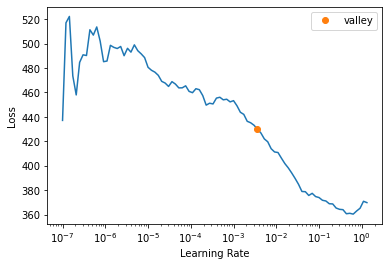

In [46]:
# Create a tabular learner and find optimal learning rate
learn = tabular_learner(dls, metrics=mae)
learn.lr_find()

### Results Display
In this final step, we display the results of the trained neural network model on the test data.

In [47]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.show_results()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,margin,margin_pred
0,1.0,19.0,1.0,0.425559,-1.116057,-1.533336,-32.0,0.030044
1,9.0,11.0,1.0,0.692305,-0.232516,-1.290216,-18.0,0.010263
2,10.0,16.0,1.0,0.474058,0.501067,0.342158,3.0,0.038365
3,4.0,11.0,1.0,-0.168556,-0.301416,-0.699783,-36.0,0.046635
4,1.0,1.0,1.0,0.187105,0.468643,0.099038,-8.0,0.048010
5,8.0,12.0,1.0,-1.417411,-1.059316,0.620009,14.0,0.061685
6,11.0,19.0,1.0,1.039883,-1.484875,-1.429142,-14.0,0.011025
7,5.0,9.0,1.0,-0.156431,-0.443269,-0.734514,6.0,0.044527
8,2.0,2.0,1.0,0.902468,-0.171722,-1.359679,-7.0,0.000190


### Exporting Results and Data
This part of the code exports the trained model and the predicted data to external files.

In [38]:
learn.export('neural_net')

#pdf.to_csv('predicted_data.csv', index=False)

/usr/local/anaconda3/lib/python3.8/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


AttributeError: 'NoneType' object has no attribute 'numpy'

In [ ]:
hypothetical_game = {
    'home_team': 'Tennessee',
    'home_conference': 'SEC',
    'home_elo': 1707.6,
    'away_team': 'Alabama',
    'away_conference': 'SEC',
    'away_elo': 1739.1,
    'neutral_site': False,
}

### Future Integration
Hypothetical game analysis, pending predicted or imported team elo values.